![](./img/robert-ritchie-JEicDFy5Cd8-unsplash_Copy.jpg)  

Photo by <a href="https://unsplash.com/@robert___ritchie?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Robert Ritchie</a> on <a href="https://unsplash.com/fr/photos/JEicDFy5Cd8?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

Preambule: here is the orignal notebook that can be run flawlessly. Since Plotly data visualisation can't be saved offline with their interactive property, this notebook used images saved to show the plots.  

# Datasets & Problem Statement


The datasets come form the [open data platform provided by the city of Seattle](https://data.seattle.gov/). Seattle’s Building Energy Benchmarking and Reporting Program requires owners of non-residential and multifamily buildings (20,000 square feet or larger) to track energy performance and annually report to the City of Seattle. Buildings account for 33% of Seattle's core emissions. The benchmarking policy supports Seattle's goals to reduce energy use and greenhouse gas emissions from existing buildings.  

In 2013, the City of Seattle adopted a Climate Action Plan to achieve zero net greenhouse gas (GHG) emissions by 2050. Annual benchmarking, reporting and disclosing of building performance are foundational elements of creating more market value for energy efficiency.

The records for the years from 2015 to 2020 are available except 2018.

Here i'm going to:
- first in part 1, analyze all the informatins over the differents years.
- then in the 2nd part, prepare the dataset for a specific year in order to make a prediction model of the total GHG emissions depending on the buildings' characteristics.

This is the first part.

---

## Requirements & imports

If the notebook in run in colab / kaggle, or more generally in a new python virtual environnemnt, you should probably start by installing all the libraries. For that purpose use:
`pip install requirements.txt` or with the command line:

In [1]:
!pip install dython missingno

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


This part is specific to colab in order to access the files / datasets stored in the drive:

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


we can list them:

In [ ]:
!ls drive/MyDrive/energy/data

here are the paths in constants:

In [16]:
DATA_DIR = 'drive/MyDrive/energy/data'
DATA_OUTPUT = 'drive/MyDrive/energy/'

then import all the needed libs:

In [2]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import missingno as msno
from dython.nominal import associations

import plotly.express as px
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

---

# First insight & datasets homogenization 

Let's begin by detecting what may differs in the various datasets over the years, in order to be able later to compare them, and study the evolutions.

## Breef peek into the building IDs over years

How many unique ids are there for each year?

In [17]:
csv_files = [f for f in os.listdir(DATA_DIR) if 'csv' in f]
print(csv_files)

dfs = {}
for csv_file in csv_files:
    dfs[int(csv_file[:4])] = pd.read_csv(os.path.join(DATA_DIR, csv_file))

print("The field 'OSEBuildingID' can be used as index:")
for k, v in dfs.items():
    print(f"For {k} - nb unique IDs: {v.OSEBuildingID.nunique()} - shape: {v.shape} - duplicated rows: {v.duplicated().sum()}")

['2017-building-energy-benchmarking.csv', '2019-building-energy-benchmarking.csv', '2020-building-energy-benchmarking.csv', '2016-building-energy-benchmarking.csv', '2015-building-energy-benchmarking.csv']
The field 'OSEBuildingID' can be used as index:
For 2017 - nb unique IDs: 3461 - shape: (3461, 45) - duplicated rows: 0
For 2019 - nb unique IDs: 3581 - shape: (3581, 42) - duplicated rows: 0
For 2020 - nb unique IDs: 3628 - shape: (3628, 42) - duplicated rows: 0
For 2016 - nb unique IDs: 3376 - shape: (3376, 46) - duplicated rows: 0
For 2015 - nb unique IDs: 3340 - shape: (3340, 42) - duplicated rows: 0


We can see that a large proportion of the building IDs are present in the recent benchmarkings. The number of recordings increase probably because more data is provided or new buildings are created. 

In [18]:
for i, k in enumerate(dfs.keys()):
    if i == 0:
        continue
    nb_rows = dfs[list(dfs.keys())[i]].shape[0]
    previous_ids = dfs[list(dfs.keys())[i-1]].OSEBuildingID.unique()
    current_ids = dfs[list(dfs.keys())[i]].OSEBuildingID.unique()
    nb_common_ids = np.intersect1d(previous_ids, current_ids, assume_unique=True).shape[0]
    print(f"For {k}, IDs in common w. previous year {nb_common_ids / nb_rows * 100:.1f}%")

For 2019, IDs in common w. previous year 94.7%
For 2020, IDs in common w. previous year 97.3%
For 2016, IDs in common w. previous year 96.1%
For 2015, IDs in common w. previous year 98.3%


## Analysis of columns in common or absent

In [19]:
pd.concat([df.dtypes for df in dfs.values()], axis=1) \
    .rename(columns={i: k for (i, k) in zip(range(len(dfs.keys())), dfs.keys())}) \
    .style.applymap(lambda x: '' if x==x else 'background-color: yellow')

,2017,2019,2020,2016,2015
OSEBuildingID,int64,int64,int64,int64,int64
DataYear,int64,int64,int64,int64,int64
BuildingType,object,object,object,object,object
PrimaryPropertyType,object,object,nan,object,object
PropertyName,object,nan,nan,object,object
Address,object,object,object,object,nan
City,object,object,object,object,nan
State,object,object,object,object,nan
ZipCode,float64,float64,float64,float64,nan
TaxParcelIdentificationNumber,object,object,object,object,object


we can easily see that 'Location' in the 2015 dataset is in fact an aggregation of 'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude' of the dataset of the following years

In [20]:
print(dfs[2015].Location.head(2).values)
dfs[2016][['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude' ]].head(2)

['411 W REPUBLICAN ST\nSEATTLE, WA 98119\n(47.62305186, -122.3623121)'
 '6100 CORSON AVE S\nSEATTLE, WA 98108\n(47.5477336, -122.3207866)']


,Address,City,State,ZipCode,Latitude,Longitude
0,405 Olive way,Seattle,WA,98101.0,47.61220,-122.33799
1,724 Pine street,Seattle,WA,98101.0,47.61317,-122.33393


in the 2015 dataset 'GHGEmissions(MetricTonsCO2e)' and 'GHGEmissionsIntensity(kgCO2e/ft2)' are similar to 'TotalGHGEmissions', 'GHGEmissionsIntensity' in the 2016 version

In [21]:
display(dfs[2015][['GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']].describe().T.round(1))
display(dfs[2016][['TotalGHGEmissions', 'GHGEmissionsIntensity']].describe().T.round(1))

,count,mean,std,min,25%,50%,75%,max
GHGEmissions(MetricTonsCO2e),3330.0,110.1,409.5,0.0,9.3,32.7,88.6,11824.9
GHGEmissionsIntensity(kgCO2e/ft2),3330.0,1.0,1.6,0.0,0.1,0.5,1.2,31.4


,count,mean,std,min,25%,50%,75%,max
TotalGHGEmissions,3367.0,119.7,538.8,-0.8,9.5,33.9,93.9,16871.0
GHGEmissionsIntensity,3367.0,1.2,1.8,-0.0,0.2,0.6,1.4,34.1


'Comments' & 'Comment' are useless because those columns are nearly always full of Nan... 'PropertyName' has been renamed to 'BuildingName' since 2019:

In [22]:
print("for year 2017:")
display(dfs[2017][['PropertyName']].head())
print("for year 2019:")
display(dfs[2019][['BuildingName']].head())

for year 2017:


,PropertyName
0,Mayflower park hotel
1,Paramount Hotel
2,84SC9-The Westin Seattle
3,HOTEL MAX
4,WARWICK SEATTLE HOTEL (ID8)


for year 2019:


,BuildingName
0,MAYFLOWER PARK HOTEL
1,PARAMOUNT HOTEL
2,WESTIN HOTEL (Parent Building)
3,HOTEL MAX
4,WARWICK SEATTLE HOTEL


'YearsENERGYSTARCertified' contains all the years of certifications - all the years between 2000 & 2020 (so we'll count the number of certifications)

In [23]:
display(dfs[2017][~dfs[2017]['YearsENERGYSTARCertified'].isnull()][['OSEBuildingID', 'YearsENERGYSTARCertified' ]].head(2))
print(dfs[2019]['ComplianceIssue'].unique())

,OSEBuildingID,YearsENERGYSTARCertified
37,50,2016
44,57,201820172016


['No Issue' 'Missing 2019 EUI or Electricity Data'
 'Account Requires Verification' 'Default Data'
 'Portfolio Manager Account Not Shared' 'Contact the Help Desk']


the 2019 dataset is the only one to have both 'PrimaryPropertyType' & 'EPAPropertyType' but the 2nd one is more informative, and finally the same thing as 'BuildingType'

In [24]:
df_19 = dfs[2019].copy()
df_19[df_19.PrimaryPropertyType != df_19.EPAPropertyType][['OSEBuildingID', 'BuildingName', 'BuildingType', 'PrimaryPropertyType', 'EPAPropertyType' ]]

,OSEBuildingID,BuildingName,BuildingType,PrimaryPropertyType,EPAPropertyType
9,13,LYON BUILDING,Multifamily MR (5-9),Multifamily Housing,Multifamily MR (5-9)
110,183,"EMERSON HALL, SEATTLE PACIFIC UNIVERSITY",Multifamily LR (1-4),Residence Hall/Dormitory,Multifamily LR (1-4)
160,265,2024 THIRD AVE/YWCA,Multifamily MR (5-9),Multifamily Housing,Multifamily MR (5-9)
161,266,WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK A...,Multifamily LR (1-4),Multifamily Housing,Multifamily LR (1-4)
169,280,THE WINTONIA,Multifamily MR (5-9),Multifamily Housing,Multifamily MR (5-9)
...,...,...,...,...,...
3573,50535,UPTON FLATS AT HIGH POINT,Multifamily LR (1-4),NaN,NaN
3575,50539,KIARA,Multifamily HR (10+),Multifamily Housing,Multifamily HR (10+)
3576,50540,EVEN HOTELS & STAYBRIDGE SUITES,NonResidential,NaN,NaN
3579,50633,BROADWAY ESTATES LLC,Multifamily MR (5-9),Multifamily Housing,Multifamily MR (5-9)


But 'ListOfAllPropertyUseTypes' add many informations. It'll be interesting to count the number of different types

In [25]:
display(dfs[2017][['ListOfAllPropertyUseTypes']].head())

,ListOfAllPropertyUseTypes
0,Hotel
1,"Hotel, Parking, Restaurant"
2,"Hotel, Parking, Swimming Pool"
3,Hotel
4,"Hotel, Parking, Swimming Pool"


## Aggregation of the datasets for all the years

Now we are able to concatenate all the files together:

In [26]:
df_16 = pd.read_csv(os.path.join(DATA_DIR, '2016-building-energy-benchmarking.csv'), index_col=0) \
    .rename(columns={'PropertyName': 'BuildingName'})

df_15 = pd.read_csv(os.path.join(DATA_DIR, '2015-building-energy-benchmarking.csv'), index_col=0) \
    .drop(columns=['Location']) \
    .rename(columns={
         'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions', 
         'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity',
         'PropertyName': 'BuildingName'}) \
    .join(df_16[['Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']])

df_17 = pd.read_csv(os.path.join(DATA_DIR, '2017-building-energy-benchmarking.csv'), index_col=0) \
    .rename(columns={'PropertyName': 'BuildingName'})

df_19 = pd.read_csv(os.path.join(DATA_DIR, '2019-building-energy-benchmarking.csv'), index_col=0) \
     .drop(columns=['EPAPropertyType']) \
     .join(df_17[['NumberofBuildings','ListOfAllPropertyUseTypes']])

df_20 = pd.read_csv(os.path.join(DATA_DIR, '2020-building-energy-benchmarking.csv'), index_col=0) \
     .drop(columns=['EPAPropertyType']) \
     .join(df_19[['PrimaryPropertyType']]) \
     .join(df_17[['ListOfAllPropertyUseTypes']])

dfs = [df_15, df_16, df_17, df_19, df_20]

pd.concat([df.dtypes for df in dfs], axis=1) \
    .rename(columns={i: k for (i, k) in zip(range(len(dfs)), ['2015', '2016', '2017', '2019', '2020'])}) \
    .style.applymap(lambda x: '' if x==x else 'background-color: yellow')

,2015,2016,2017,2019,2020
DataYear,int64,int64,int64,int64,int64
BuildingType,object,object,object,object,object
PrimaryPropertyType,object,object,object,object,object
BuildingName,object,object,object,object,object
TaxParcelIdentificationNumber,object,object,object,object,object
CouncilDistrictCode,int64,int64,float64,float64,float64
Neighborhood,object,object,object,object,object
YearBuilt,int64,int64,float64,int64,int64
NumberofBuildings,int64,float64,float64,float64,int64
NumberofFloors,float64,int64,float64,int64,int64


Further investigations for the EnergySTAR score compliance criteria would be needed, but are out of scope of this study

In [27]:
df_concat = pd.concat(dfs, axis=0).drop(columns=['Comment', 'Comments', 'OtherFuelUse(kBtu)']) 
print(df_concat.shape)
df_concat.head()

(17386, 45)


,DataYear,BuildingType,PrimaryPropertyType,BuildingName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,ComplianceStatus,Outlier,Address,City,State,ZipCode,Latitude,Longitude,ComplianceIssue
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
21548,2015,Multifamily LR (1-4),Low-Rise Multifamily,PUGET VISTA APTS,1992200030,7.0,MAGNOLIA / QUEEN ANNE,1967.0,1.0,4.0,40086,6133.0,33953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,Not Compliant,NaN,411 W Republican Street,Seattle,WA,98119.0,47.62304,-122.36240,NaN
26379,2015,NonResidential,Hotel,GEORGETOWN INN,6920700025,2.0,GREATER DUWAMISH,1992.0,1.0,3.0,22452,0.0,22452.0,Hotel,Hotel,22452.0,NaN,NaN,NaN,NaN,NaN,78.0,60.3,61.5,118.2,122.0,1354219.0,1381137.0,0.0,172881.0,589893.0,7644.0,764350.0,44.71,1.88,No,Compliant,NaN,6100 Corson Ave South,Seattle,WA,98108.0,47.54774,-122.32091,NaN
26713,2015,Multifamily HR (10+),High-Rise Multifamily,QUINTESSA APTS,5247800955,7.0,DOWNTOWN,2007.0,1.0,13.0,90959,0.0,90959.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,48.0,52.2,115.4,126.2,4361755.0,4748161.0,0.0,829363.0,2829904.0,15320.0,1531968.0,101.09,0.98,No,Compliant,NaN,"201 Yesler Way, Ste 100",Seattle,WA,98104.0,47.60154,-122.33121,NaN
102,2015,NonResidential,Hotel,MARRIOTT RESIDENCE INN,1984200065,3.0,LAKE UNION,1990.0,1.0,7.0,282863,44766.0,238097.0,"Hotel, Parking",Hotel,235788.0,Parking,51537.0,NaN,NaN,NaN,40.0,79.9,85.3,178.1,186.6,18829136.0,20123722.0,0.0,3117920.0,10638785.0,81908.0,8190794.0,509.18,1.64,No,Compliant,NaN,800 Fairview Ave. N,Seattle,WA,98109.0,47.62642,-122.33325,NaN
503,2015,NonResidential,Supermarket/Grocery Store,RESTAURANT DEPOT,1824049003,2.0,GREATER DUWAMISH,2008.0,1.0,1.0,63225,0.0,63225.0,Supermarket/Grocery Store,Supermarket/Grocery Store,63225.0,NaN,NaN,NaN,NaN,NaN,100.0,104.7,104.7,328.8,328.8,6619941.0,6619941.0,0.0,1940194.0,6620217.0,0.0,0.0,46.15,0.28,No,Compliant,NaN,3670 E MARGINAL WAY S,Seattle,WA,98134.0,47.56895,-122.33775,NaN


---

# Macro Analysis - Evolution over years

## Dataset Preparation

How many missing values do we have? The table below provides an overview of missing values both vertically (for each variable) but also horizontally (per records) before and after imputation:

before imputation


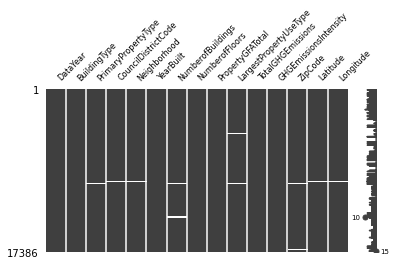

after imputation


<AxesSubplot:>

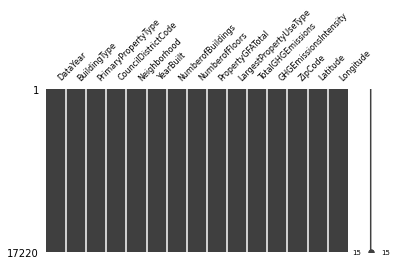

In [28]:
df_all_years = df_concat.copy()

col_kept = ['DataYear', 'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood',
        'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType', 
        'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ZipCode', 'Latitude', 'Longitude']

df_all_years = df_all_years[col_kept]
print("before imputation")
msno.matrix(df_all_years, figsize=(6, 3), fontsize=8)
plt.show()


# fillna with same IDs
years = sorted(df_all_years.DataYear.unique())
for year in years:
    year_ref = year + 1 if year != 2020 else 2019
    df_all_years[df_all_years.DataYear == year] = \
    df_all_years[df_all_years.DataYear == year].fillna(df_all_years[df_all_years.DataYear == year_ref])

    
# Keep only the rows with at least 13 non-NA values on 15 cols.
df_all_years.dropna(thresh=13, inplace=True)


# fill zipcode na with values nearby
geo_cols = ['ZipCode', 'Latitude', 'Longitude']
df_all_years[geo_cols] = pd.DataFrame(
    data=KNNImputer(n_neighbors=5).fit_transform(df_all_years[geo_cols]),
    index=df_all_years.index,
    columns=geo_cols
)


PrimaryPropertyType_to_LargestPropertyUseType = df_all_years.groupby('PrimaryPropertyType')['LargestPropertyUseType'].agg(pd.Series.mode).to_dict()
LargestPropertyUseType_to_PrimaryPropertyType = df_all_years.groupby('LargestPropertyUseType')['PrimaryPropertyType'].agg(pd.Series.mode).to_dict()

#df.B = df.B.fillna(df.A.map(dict))

df_all_years.LargestPropertyUseType = df_all_years.LargestPropertyUseType \
    .fillna(df_all_years.PrimaryPropertyType.map(PrimaryPropertyType_to_LargestPropertyUseType))

df_all_years.PrimaryPropertyType = df_all_years.PrimaryPropertyType \
    .fillna(df_all_years.LargestPropertyUseType.map(LargestPropertyUseType_to_PrimaryPropertyType))

# drop few lines with still NaNs
df_all_years.dropna(inplace=True)

assert df_all_years.isnull().sum().sum() == 0


print("after imputation")
msno.matrix(df_all_years, figsize=(6, 3), fontsize=8)

## First analysis

Let's get rid off "shared" neighborhoods and water, for the sake of simplicity

In [29]:
df_all_years.Neighborhood = df_all_years.Neighborhood.str.lower()
df_all_years.Neighborhood.replace('delridge neighborhoods', 'delridge', inplace=True)
px.histogram(df_all_years, y='Neighborhood', width=900, height=450)

In [30]:
df_mean_neighborhood = df_all_years[~df_all_years.Neighborhood.str.contains('shared') & 
                                    ~df_all_years.Neighborhood.str.contains('water')] \
    .groupby(['DataYear', 'Neighborhood'])[['TotalGHGEmissions']].mean().round(2)

display(df_mean_neighborhood.head())

px.area(df_mean_neighborhood.reset_index(), x='DataYear', y='TotalGHGEmissions', color='Neighborhood',
        width=800, height=400)

TotalGHGEmissions
DataYear Neighborhood                   
2015     ballard                   78.89
         central                   92.14
         delridge                  67.04
         downtown                 187.85
         east                     171.91

## New buildings vs existing ones

Actually new ids doesn't correspond to new buildings but to buildings that weren't recorded previsously. So we have to use the 'YearBuilt' field instead.

In [31]:
for year in years[1:]:
    #year_ref = year + 1 if year != 2020 else 2019
    new_building_ids = np.setdiff1d(
        df_all_years[df_all_years.DataYear == year].index.values,
        df_all_years[df_all_years.DataYear == year - 1].index.values
    ) 
    print(f"New ids in the dataset of year: {year}:")
#     print(new_building_ids)
    display(df_all_years.loc[new_building_ids][['YearBuilt']].describe().T)

New ids in the dataset of year: 2016:


,count,mean,std,min,25%,50%,75%,max
YearBuilt,320.0,1998.634375,28.923975,1900.0,1993.5,2014.0,2015.0,2018.0


New ids in the dataset of year: 2017:


,count,mean,std,min,25%,50%,75%,max
YearBuilt,325.0,1996.464615,32.366671,1900.0,1987.0,2015.0,2016.0,2019.0


New ids in the dataset of year: 2019:


,count,mean,std,min,25%,50%,75%,max
YearBuilt,16856.0,1970.033697,33.584945,1896.0,1950.0,1977.0,1999.0,2019.0


New ids in the dataset of year: 2020:


,count,mean,std,min,25%,50%,75%,max
YearBuilt,104.0,1992.307692,42.073924,1900.0,1982.25,2018.0,2019.0,2019.0


map with counts: where new buildings are located ??????????????????????????????

Number of new buildings (no data for year 2018):

<AxesSubplot:xlabel='YearBuilt'>

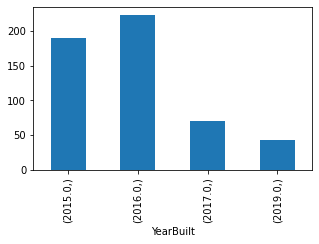

In [32]:
df_new_buildings = df_all_years[df_all_years.YearBuilt.isin(df_all_years.DataYear.unique())]
df_new_buildings[['YearBuilt']].value_counts() \
    .sort_index().plot(kind='bar', figsize=(5, 3))

proportion of new buildings over years

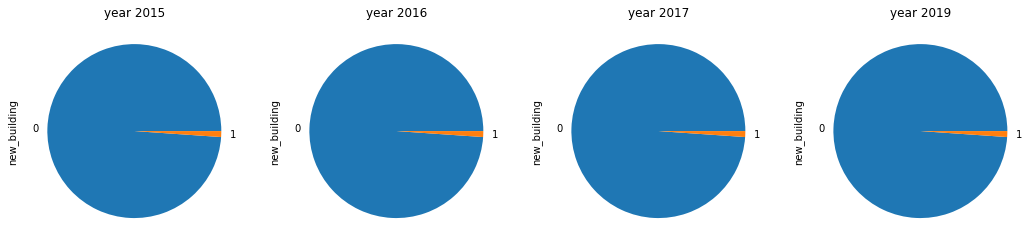

In [33]:
df_all_years['new_building'] = df_all_years.YearBuilt.isin(df_all_years.DataYear.unique()).astype('int') #, 'new_building'] = 'Yes'

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
for i, year in enumerate([2015, 2016, 2017, 2019]):
    df_all_years[df_all_years.DataYear == 2016]['new_building'].value_counts() \
        .plot.pie(y='new_building', ax=axes[i], title=f"year {year}")

<AxesSubplot:xlabel='DataYear'>

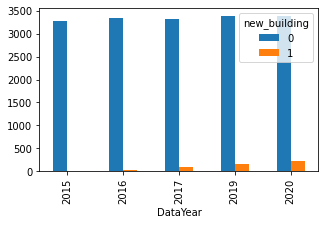

In [34]:
pd.DataFrame(df_all_years[['DataYear', 'new_building']].value_counts()) \
    .reset_index().rename(columns={0: 'count'}).sort_values(['DataYear', 'new_building']) \
    .pivot(index='DataYear', columns='new_building', values='count') \
    .plot.bar(figsize=(5, 3))

Performance vs mean of existing

In [35]:
df_all_years.groupby(['DataYear', 'new_building']).agg(
    median_emmission_intensity=("GHGEmissionsIntensity", "median"),
    median_total_emmission=("TotalGHGEmissions", "median"),
).reset_index().pivot(
    index='DataYear', 
    columns='new_building', 
    values=['median_emmission_intensity', 'median_total_emmission']
).round(3)

median_emmission_intensity        median_total_emmission        
new_building                          0      1                      0       1
DataYear                                                                     
2015                               0.46  1.305                  32.77  364.12
2016                               0.61  0.550                  33.50   51.26
2017                               0.58  0.541                  31.81   52.57
2019                               0.70  0.700                  33.00   60.95
2020                               0.60  0.700                  28.75   54.05

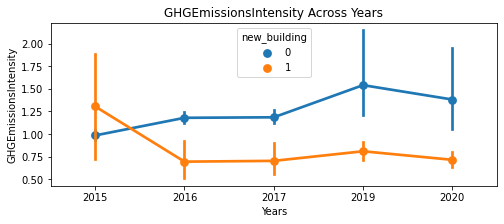

In [36]:
plt.figure(figsize=(8, 3))
sns.pointplot(x=df_all_years.DataYear, y=df_all_years.GHGEmissionsIntensity, hue=df_all_years.new_building)
plt.xlabel("Years")
plt.ylabel("GHGEmissionsIntensity") 
plt.title("GHGEmissionsIntensity Across Years")
plt.show()

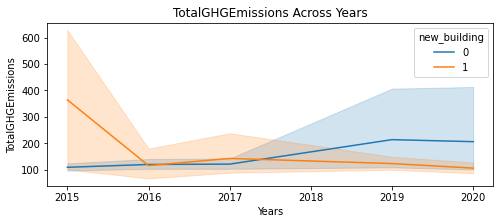

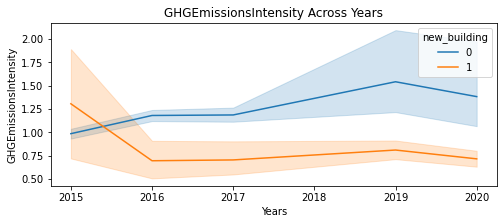

In [37]:
# same thing but less interesting visually
# plt.figure(figsize=(8, 3))
# sns.pointplot(x=df_all_years.DataYear, y=df_all_years.TotalGHGEmissions, hue=df_all_years.new_building)
# plt.xlabel("Years")
# plt.ylabel("TotalGHGEmissions") 
# plt.title("TotalGHGEmissions Across Years")
# plt.show()


plt.figure(figsize=(8, 3))
sns.lineplot(x='DataYear', y="TotalGHGEmissions", hue="new_building", data=df_all_years)
plt.xlabel("Years")
plt.ylabel("TotalGHGEmissions") 
plt.title("TotalGHGEmissions Across Years")
plt.show()

plt.figure(figsize=(8, 3))
sns.lineplot(x='DataYear', y="GHGEmissionsIntensity", hue="new_building", data=df_all_years)
plt.xlabel("Years")
plt.ylabel("GHGEmissionsIntensity") 
plt.title("GHGEmissionsIntensity Across Years")
plt.show()

In [38]:
def evolution_over_years_per_criteria(df, criteria, intensity_or_total):

    df_mean =  df.groupby(['DataYear', criteria, 'new_building'])[[intensity_or_total]].mean().round(2)
    # display(df_mean_neighborhood.head())
    px.area(df_mean.reset_index(), x='DataYear', y=intensity_or_total, color=criteria, 
            line_group="new_building", width=800, height=450).show()

    
evolution_over_years_per_criteria(
    df_all_years[~df_all_years.Neighborhood.str.contains('shared') & 
                 ~df_all_years.Neighborhood.str.contains('water')],
    'Neighborhood',
    'TotalGHGEmissions'
)

In [39]:
evolution_over_years_per_criteria(
    df_all_years[~df_all_years.Neighborhood.str.contains('shared') & 
                 ~df_all_years.Neighborhood.str.contains('water')],
    'Neighborhood',
    'GHGEmissionsIntensity'
)

In [40]:
px.box(
    df_all_years[df_all_years.GHGEmissionsIntensity < 10],
    x="BuildingType",
    y="GHGEmissionsIntensity", 
    color="new_building",
    notched=True,
    width=800,
    height=550
).show()

In [41]:
df_all_years.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'TotalGHGEmissions', 'GHGEmissionsIntensity', 'ZipCode', 'Latitude',
       'Longitude', 'new_building'],
      dtype='object')

## Analysis of existing buildings

evolution by type, neighborhood, nb of floors, nb of buildings, area

<AxesSubplot:ylabel='BuildingType'>

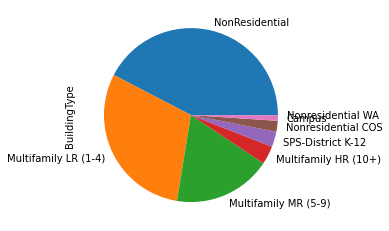

In [42]:
df_all_years.BuildingType.value_counts().plot.pie()

In [43]:
evolution_over_years_per_criteria(
    df_all_years[~df_all_years.Neighborhood.str.contains('shared') & 
                 ~df_all_years.Neighborhood.str.contains('water')],
    'BuildingType',
    'GHGEmissionsIntensity'
)

evolution_over_years_per_criteria(
    df_all_years[~df_all_years.Neighborhood.str.contains('shared') & 
                 ~df_all_years.Neighborhood.str.contains('water')],
    'BuildingType',
    'TotalGHGEmissions'
)

---

# Year 2016 - Analysis in Depth & Data Cleansing

Number of rows and columns for the year 2016. We can clearly see that we've to few records...

In [44]:
df = df_concat[df_concat.DataYear == 2016]
df.shape

(3376, 45)

## Duplicated rows
There isn't any duplicated records in this dataset:

In [45]:
df.duplicated().sum(), df.index.duplicated().sum()

(0, 0)

## Overview of missing values

Overview of missing values for each columns

<AxesSubplot:>

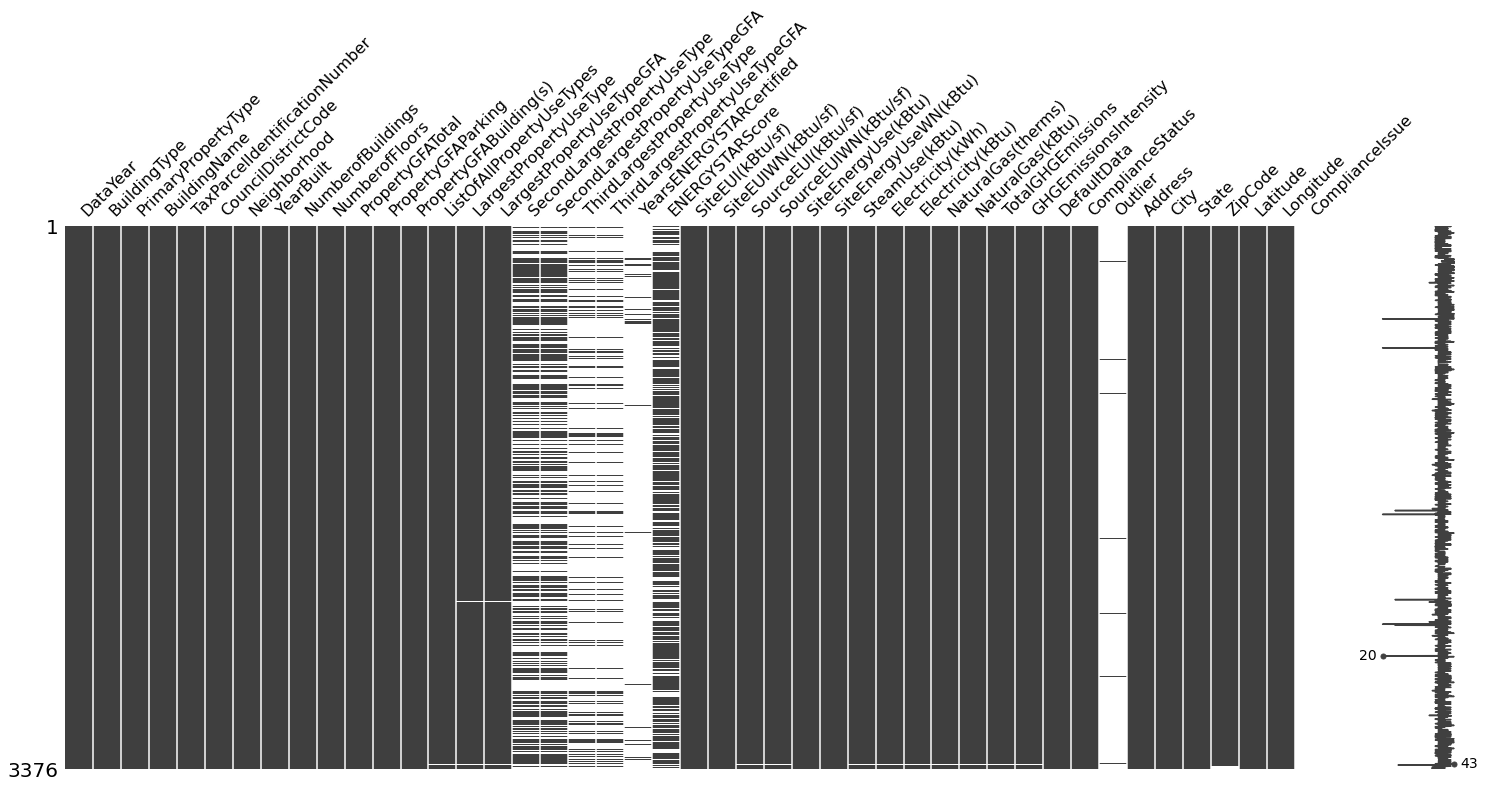

In [46]:
msno.matrix(df)

In [47]:
def describe_df(df):
    list_item = []
    for col in df.columns:
        list_item.append([
            col, 
            df[col].dtype,
            df[col].isna().sum(),
            round(df[col].isna().sum()/len(df[col])*100, 2),
            df[col].nunique(),
            round(df[col].nunique()/len(df[col])*100, 2),
            list(df[col].unique()[:5])
        ])
    return pd.DataFrame(
        columns=['feature', 'type', '# null', '% null', '# unique', '% unique', 'sample'],
        data = list_item
    )

## Irrelevant columns  

First we remove the columns that aren't relevant for sure:
- 'BuildingName': nearly unique for every recording & not usefull
- 'TaxParcelIdentificationNumber': nearly unique for every recording & not usefull
- 'DataYear': always 2016
- 'City': always Seattle (of course...)
- 'State': same reason
- 'ComplianceIssue': used for later years
- 'YearsENERGYSTARCertified': nearly always null

In [48]:
describe_df(df[['BuildingName', 'TaxParcelIdentificationNumber', 'DataYear', 'City', 'State',
                 'ComplianceIssue', 'YearsENERGYSTARCertified', 'DefaultData', 'Address']])

,feature,type,# null,% null,# unique,% unique,sample
0,BuildingName,object,0,0.00,3362,99.59,"[Mayflower park hotel, Paramount Hotel, 5673-T..."
1,TaxParcelIdentificationNumber,object,0,0.00,3268,96.80,"[0659000030, 0659000220, 0659000475, 065900064..."
2,DataYear,int64,0,0.00,1,0.03,[2016]
3,City,object,0,0.00,1,0.03,[Seattle]
4,State,object,0,0.00,1,0.03,[WA]
5,ComplianceIssue,object,3376,100.00,0,0.00,[nan]
6,YearsENERGYSTARCertified,object,3257,96.48,65,1.93,"[nan, 2016, 2014, 2012, 20172015]"
7,DefaultData,object,0,0.00,2,0.06,"[False, True]"
8,Address,object,0,0.00,3354,99.35,"[405 Olive way, 724 Pine street, 1900 5th Aven..."


In [49]:
df = df.drop(columns=['BuildingName', 'TaxParcelIdentificationNumber', 'City', 'State', \
                 'ComplianceIssue', 'YearsENERGYSTARCertified', 'DefaultData', 'Address']) 
# 'DataYear' drop later

## Type mismatch  
Does the column's type match the information it contains? Yes for most of the cases but the following ones should be integers : 'YearBuilt', 'CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'ZipCode'

In [50]:
cols_to_int = ['YearBuilt', 'CouncilDistrictCode', 'NumberofBuildings', 'NumberofFloors', 'ZipCode']
describe_df(df[cols_to_int])

,feature,type,# null,% null,# unique,% unique,sample
0,YearBuilt,float64,0,0.00,113,3.35,"[1927.0, 1996.0, 1969.0, 1926.0, 1980.0]"
1,CouncilDistrictCode,float64,0,0.00,7,0.21,"[7.0, 3.0, 2.0, 4.0, 5.0]"
2,NumberofBuildings,float64,8,0.24,17,0.50,"[1.0, 3.0, 0.0, 2.0, 4.0]"
3,NumberofFloors,float64,0,0.00,50,1.48,"[12.0, 11.0, 41.0, 10.0, 18.0]"
4,ZipCode,float64,16,0.47,55,1.63,"[98101.0, 98121.0, 98104.0, 98154.0, 98118.0]"


Prior to this, we have to replace NaN values, at the same time we see that there are 'NumberOfBuildings' equal to 0:

<AxesSubplot:>

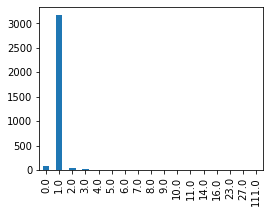

In [51]:
df.NumberofBuildings.value_counts().sort_index().plot(kind='bar', figsize=(4, 3))

<AxesSubplot:>

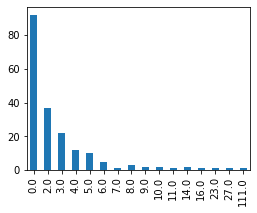

In [52]:
df[df.NumberofBuildings !=1].NumberofBuildings.value_counts().sort_index().plot(kind='bar', figsize=(4, 3))

In [53]:
# df.NumberofBuildings.value_counts().plot(kind='hist', figsize=(3, 3))

df.loc[df.NumberofBuildings > 6, ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'TotalGHGEmissions', 'GHGEmissionsIntensity']] \
    .sort_values(by=['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal'], ascending=True)

,NumberofBuildings,NumberofFloors,PropertyGFATotal,TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,,,,,
828,7.0,14.0,1765970,12307.16,6.97
49705,8.0,0.0,502030,549.11,1.09
23071,8.0,1.0,415632,3278.11,7.89
21196,8.0,4.0,185403,28.60,0.15
24498,9.0,3.0,58523,13.16,0.22
276,9.0,8.0,1158691,10734.57,9.26
24086,10.0,0.0,230971,405.05,1.75
25241,10.0,3.0,166858,28.83,0.17
211,11.0,2.0,694072,362.82,0.52


In [54]:
df.NumberofBuildings.replace([np.nan, 0], df.NumberofBuildings.mode()[0], inplace=True)

## Imputation of NaNs

Let's use the KNN imputer of scikit-learn to fill the ZipCode Nan based on the location

In [55]:
cols = ['ZipCode', 'Latitude', 'Longitude']
df_tmp = df[cols]
df_tmp = pd.DataFrame(
    data=KNNImputer(n_neighbors=5).fit_transform(df_tmp),
    index=df.index,
    columns=cols
)

df = df.drop(columns=cols).join(df_tmp)

df[cols_to_int] = df[cols_to_int].astype('int')
df[['CouncilDistrictCode', 'ZipCode']] = df[['CouncilDistrictCode', 'ZipCode']].astype('object')

__Other missing values__  
There are many columns with the same number of NaNs (in our case less than nine recordings):

In [56]:
cols_with_few_nan = [col for col in df.columns if 0 < df[col].isnull().sum() <= 9]
print("Columns with few NaN:\n", " - ".join(cols_with_few_nan))

# https://thispointer.com/pandas-select-rows-with-all-nan-values-in-all-columns/
# df[df.isnull().all(axis=1)]

print("# rows with ALL nan in this columns' subset:", df[df[cols_with_few_nan].isnull().all(axis=1)].shape[0])
print("# rows with ONE nan in this columns' subset:", df[df[cols_with_few_nan].isnull().any(axis=1)].shape[0])

Columns with few NaN:
 ListOfAllPropertyUseTypes - SiteEUI(kBtu/sf) - SiteEUIWN(kBtu/sf) - SourceEUI(kBtu/sf) - SourceEUIWN(kBtu/sf) - SiteEnergyUse(kBtu) - SiteEnergyUseWN(kBtu) - SteamUse(kBtu) - Electricity(kWh) - Electricity(kBtu) - NaturalGas(therms) - NaturalGas(kBtu) - TotalGHGEmissions - GHGEmissionsIntensity
# rows with ALL nan in this columns' subset: 5
# rows with ONE nan in this columns' subset: 12


As there are very few recordings concerned, we can safely remove them.

In [57]:
df.dropna(subset=cols_with_few_nan, inplace=True)

'LargestPropertyUseType', 'LargestPropertyUseTypeGFA' have NaN on the same rows, it represents less than 1% of nulls, we can also remove those recordings:

In [58]:
print(df[df[['LargestPropertyUseType', 'LargestPropertyUseTypeGFA']].isnull().all(axis=1)].shape[0])
df.dropna(subset=['LargestPropertyUseType', 'LargestPropertyUseTypeGFA'], inplace=True)

11


'SecondLargestPropertyUseType' & 'SecondLargestPropertyUseTypeGFA' are null at the same time.  
'ThirdLargestPropertyUseType' & 'ThirdLargestPropertyUseTypeGFA' are also null at the same time.  
That's quite obvious, but we can easily check that when infos on the 2nd largest property are missing that's also the case for the 3rd one.

In [59]:
# rows where 'SecondLargestPropertyUseType' & 'SecondLargestPropertyUseTypeGFA' have both null:",
# df[df.SecondLargestPropertyUseType.isnull() & df.SecondLargestPropertyUseTypeGFA.isnull()].shape[0]

# rows where 'ThirdLargestPropertyUseType' & 'ThirdLargestPropertyUseTypeGFA' have both null:",
# df[df.ThirdLargestPropertyUseType.isnull() & df.ThirdLargestPropertyUseTypeGFA.isnull()].shape[0]

# df[df.SecondLargestPropertyUseType.isnull() & df.ThirdLargestPropertyUseType.isnull()].shape[0]

That's because the concerned buildings are of only one property. When the 2nd & 3rd properties are missing, the 'NbProperty' juste created before is nearly always unique:

In [60]:
df['NbProperty'] = df.ListOfAllPropertyUseTypes.apply(lambda x: len(x.split(',')))
df[df.SecondLargestPropertyUseType.isnull() & df.ThirdLargestPropertyUseType.isnull()][['NbProperty']].describe().T

,count,mean,std,min,25%,50%,75%,max
NbProperty,1676.0,1.009547,0.161795,1.0,1.0,1.0,1.0,4.0


Knowing that we can replace NaNs by zeros:

In [61]:
df = df.fillna({
    'SecondLargestPropertyUseType': 0, 
    'SecondLargestPropertyUseTypeGFA': 0, 
    'ThirdLargestPropertyUseType': 0,
    'ThirdLargestPropertyUseTypeGFA': 0
})

The last columns with still Nan are "ENERGYSTARScore" & "Outlier", that we'll study later.

CouncilDistrictCode vs ZipCode

In [62]:
pd.crosstab(index=df.ZipCode, columns=df.CouncilDistrictCode).head(10)

CouncilDistrictCode,1,2,3,4,5,6,7
ZipCode,,,,,,,
98006,0,0,0,0,0,0,1
98011,0,0,0,0,0,0,1
98012,0,0,1,0,0,0,0
98013,0,0,0,0,1,1,0
98020,0,0,0,1,0,0,0
98028,0,0,0,0,0,0,1
98033,0,0,0,0,0,0,1
98040,0,1,0,0,0,0,0
98053,1,0,0,0,0,0,0


## Treatment of categorical variables

Property types

In [63]:
pty_cols = [col for col in df.select_dtypes('object').columns if "property" in col.lower()]


health_type = ["health", "hospital", "medical", "surgical", "therapy", "care", "laboratory", "clinic", "patient"]
mixed_type = ["mixed"]
# other_type = ["other"]
industrial_type = ["industrial", "warehouse", "manufacturing", "data center", "distribution", "technology"]
commercial_type = ["commercial", "supermarket", "grocery", "store", "retail", "dealership", "mall", "wholesale", "supercenter"]
services_type = ["service", "self-storage", "bank"]
residential_type = ["residential", "residence", "dormitory", "lodging", "multifamily", "housing"]
office_type = ["office"]
parking_type = ["parking"]
education_type = ["education", "school", "college", "university"]
Public_services_type = ["public service", "police", "courthouse", "fire station", "library"]
hotel_catering_type = ["hotel_catering", "restaurant", "hotel", "bar", "food"]
leisure_type = ["leisure", "performing arts", "entertainment", "fitness", "gym", "meeting", "museum", "convention", 
                "recreation", "lifestyle", "movie", "theater", "swimming pool", "bar", "nightclub", "worship facility"]


all_types = [mixed_type, health_type, industrial_type, commercial_type, services_type, residential_type, office_type, 
             education_type, Public_services_type, hotel_catering_type, leisure_type] # other_type


def clean_type(st):
    return_type = ""
    for type_lst in all_types:
        if any([kw in st.lower() for kw in type_lst]):
            return_type += type_lst[0]
            return_type += " - "
    if return_type == "":
        return "none"
    return return_type.strip()

for col in pty_cols:
    df[col] = df[col].astype('str') 
    df[col] = df[col].apply(clean_type)

it has divided the cardinality by 2

In [64]:
describe_df(df[pty_cols])

,feature,type,# null,% null,# unique,% unique,sample
0,PrimaryPropertyType,object,0,0.0,13,0.39,"[hotel_catering -, none, residential -, mixed ..."
1,ListOfAllPropertyUseTypes,object,0,0.0,144,4.29,"[hotel_catering -, hotel_catering - leisure -,..."
2,LargestPropertyUseType,object,0,0.0,19,0.57,"[hotel_catering -, public service -, leisure -..."
3,SecondLargestPropertyUseType,object,0,0.0,18,0.54,"[none, office -, hotel_catering -, education -..."
4,ThirdLargestPropertyUseType,object,0,0.0,17,0.51,"[none, hotel_catering -, leisure -, industrial..."


In [65]:
df.SecondLargestPropertyUseType.unique()

array(['none', 'office -', 'hotel_catering -', 'education -', 'health -',
       'industrial -', 'commercial -', 'health - service -', 'leisure -',
       'public service -', 'residential -', 'service -',
       'health - office -', 'hotel_catering - leisure -',
       'service - hotel_catering -', 'health - leisure -',
       'service - public service -', 'health - education -'], dtype=object)

## Univariate analysis

BuildingType

In [66]:
px.histogram(df, x='BuildingType', width=500, height=350)#, color="continent")#, template="ggplot2")

Neighborhood

In [67]:
df.Neighborhood = df.Neighborhood.str.lower()
df.Neighborhood.replace('delridge neighborhoods', 'delridge', inplace=True)
px.histogram(df, x='Neighborhood', width=500, height=400)

BuildingAge

Many less constructions were built during WWII. But we can also see that many more buildings were erected after WWII than before. 

In [68]:
px.histogram(df, x="YearBuilt", nbins=20, width=600, height=400).show()
df["BuildingAge"] = df.DataYear - df.YearBuilt
df.drop(columns=["YearBuilt", "DataYear"], inplace = True )
# px.histogram(df, x="BuildingAge", nbins=14, width=700, height=400)

__All numerical variables__

In [69]:
# px.histogram(df, x="NumberofBuildings", width=700, height=400)
# px.histogram(df, x="NumberofFloors", width=700, height=400)

for col in df.select_dtypes('number').columns:
    px.histogram(df, x=col, width=700, height=400).show()

---

In [70]:
df.PrimaryPropertyType.unique()

array(['hotel_catering -', 'none', 'residential -', 'mixed -',
       'education -', 'commercial - office -', 'service -',
       'industrial -', 'office -', 'health -', 'health - office -',
       'commercial -', 'leisure -'], dtype=object)

__probleme 'commercial office', 'health office', !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!__

## Outliers

The variable identifying outliers could be interesting for our analysis. Nonetheless, the official dataset documentation doesn't provide an accurate information on how those outliers are computed and based on what criteria.

,Outlier
NaN,3321
Low outlier,23
High outlier,9


<AxesSubplot:title={'center':'High vs. Low outliers'}, ylabel='Outlier'>

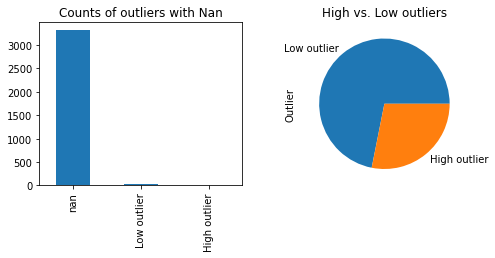

In [71]:
display(pd.DataFrame(df.Outlier.value_counts(dropna=False)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
df.Outlier.value_counts(dropna=False).plot.bar(ax=axes[0], title="Counts of outliers with Nan")
df.Outlier.value_counts().plot.pie(ax=axes[1], title=f"High vs. Low outliers")

We're going to drop those outliers:

In [72]:
print(f"Nb. rows BEFORE dropping outliers: {df.shape[0]}")
df = df[~df.Outlier.isin(['High outlier', 'Low outlier'])]
print(f"Nb. rows AFTER dropping outliers: {df.shape[0]}")

Nb. rows BEFORE dropping outliers: 3353
Nb. rows AFTER dropping outliers: 3321


Inspection of negatives values for the fields "SourceEUIWN(kBtu/sf)", "Electricity(kWh)", and "Electricity(kBtu)" (Is it positive-energy buildings? we can doubt about it because there is only one value, so we keep its absolute value:

In [73]:
cols_to_inspect = ["SourceEUIWN(kBtu/sf)", "Electricity(kWh)", "Electricity(kBtu)"]
print("# rows with ALL nan in this columns' subset:", df[(df[cols_to_inspect] < 0).all(axis=1)].shape[0])

display(df.loc[df["SourceEUIWN(kBtu/sf)"] < 0, cols_to_inspect])

df.loc[df["SourceEUIWN(kBtu/sf)"] < 0, cols_to_inspect] = \
    abs(df.loc[df["SourceEUIWN(kBtu/sf)"] < 0, cols_to_inspect])

# rows with ALL nan in this columns' subset: 1


,SourceEUIWN(kBtu/sf),Electricity(kWh),Electricity(kBtu)
OSEBuildingID,,,
49784,-2.1,-33826.80078,-115417.0


__Other numerical outliers:__

As we can see, there are many outliers when considering the IQR method. This leads to drop to many records (more than two thirds of our dataset!). We can proceed that way... Let's keep in mind for later that decision trees are not sensitive to outliers unliked linear models (since the partitioning happens based on the proportion of samples within the split ranges and not on absolute values).

In [74]:
df_cpy = df.copy()
print("initial shape :", df_cpy.shape)


def filter_iqr_outliers(df, col):
    """Use the interquartile range to detect outlier
    Args:
        df (pd.DataFrame()): the dataframe used
        col (str): the column name 
    Returns:
        a new df with the outliers' rows dropped
    
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    
    iqr = q3 - q1
    
    lower_bound = q1 - (1.5 * iqr) 
    upper_bound = q3 + (1.5 * iqr)

    return df[(lower_bound <= df[col]) & (df[col] <= upper_bound)]
    # df = df.query(f"{q1 - 1.5 * iqr} < {col} and {col} < {q3 + 1.5 * iqr}")

    
for col in df_cpy.select_dtypes("number").columns:
    nb_row_initial = df_cpy.shape[0]
    df_cpy = filter_iqr_outliers(df_cpy, col)
    nb_row_final = df_cpy.shape[0]
    print(f"for column {col}, nb outliers dropped: {nb_row_initial - nb_row_final}")
    
    
print("initial shape :", df_cpy.shape)

initial shape : (3321, 37)
for column NumberofBuildings, nb outliers dropped: 98
for column NumberofFloors, nb outliers dropped: 234
for column PropertyGFATotal, nb outliers dropped: 291
for column PropertyGFAParking, nb outliers dropped: 286
for column PropertyGFABuilding(s), nb outliers dropped: 159
for column LargestPropertyUseTypeGFA, nb outliers dropped: 94
for column SecondLargestPropertyUseTypeGFA, nb outliers dropped: 167
for column ThirdLargestPropertyUseTypeGFA, nb outliers dropped: 186
for column ENERGYSTARScore, nb outliers dropped: 376
for column SiteEUI(kBtu/sf), nb outliers dropped: 87
for column SiteEUIWN(kBtu/sf), nb outliers dropped: 32
for column SourceEUI(kBtu/sf), nb outliers dropped: 92
for column SourceEUIWN(kBtu/sf), nb outliers dropped: 36
for column SiteEnergyUse(kBtu), nb outliers dropped: 34
for column SiteEnergyUseWN(kBtu), nb outliers dropped: 17
for column SteamUse(kBtu), nb outliers dropped: 12
for column Electricity(kWh), nb outliers dropped: 33
for col

## Multivariate analysis

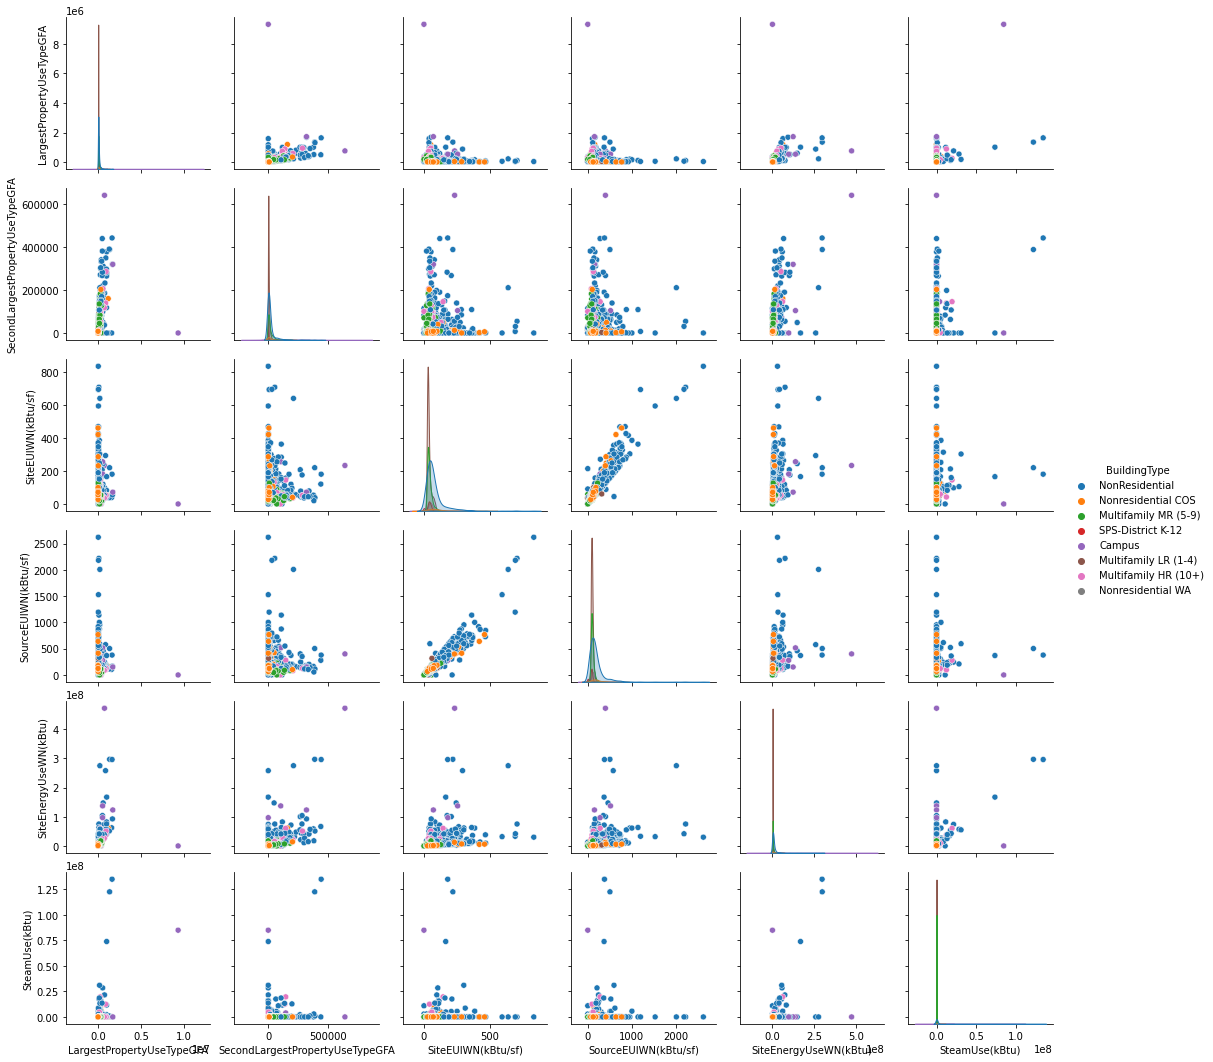

In [75]:
c = [
    'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
    'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
    'Electricity(kBtu)',  'NaturalGas(kBtu)', 'GHGEmissionsIntensity', 'BuildingType'
]

c1 = [
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
    'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 
    'BuildingType'
]

c2 = [
    'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
    'Electricity(kBtu)',  'NaturalGas(kBtu)', 'GHGEmissionsIntensity', 
    'BuildingType'
]

sns.pairplot(df[c1], hue= "BuildingType")

ffffffffffffffffffffffffffff

In [77]:
px.pie(
    df.groupby(["PrimaryPropertyType"]).agg({'TotalGHGEmissions': sum}).reset_index(),
    values='TotalGHGEmissions',
    names='PrimaryPropertyType',
    title='TotalGHGEmissions by PrimaryPropertyType',
    width=600,
    height=450
).show()

In [78]:
df.groupby(["PrimaryPropertyType", "BuildingAge"]).agg({"GHGEmissionsIntensity": "mean"}).reset_index()

,PrimaryPropertyType,BuildingAge,GHGEmissionsIntensity
0,commercial -,5,5.575000
1,commercial -,6,2.000000
2,commercial -,8,1.796667
3,commercial -,10,2.470000
4,commercial -,11,1.770000
...,...,...,...
824,service -,98,0.420000
825,service -,101,0.010000
826,service -,105,0.640000
827,service -,106,0.600000


In [79]:
px.box(
    df[df.GHGEmissionsIntensity < 10],
    x="PrimaryPropertyType",
    y="GHGEmissionsIntensity", 
    notched=True,
    width=800,
    height=450
).show()

In [80]:
px.box(
    df[df.TotalGHGEmissions < 1000],
    x="PrimaryPropertyType",
    y="TotalGHGEmissions", 
#     color="smoker",
    notched=True,
    width=800,
    height=450
).show()

### Evolution of emssions over years for each primary property type

In [81]:
df_temp = df.groupby(["PrimaryPropertyType", "BuildingAge"]).agg({"GHGEmissionsIntensity": "mean"}).reset_index()

# not really usefull
# px.line(
#     df_temp[df_temp.GHGEmissionsIntensity < 10].sort_values(by="BuildingAge"),
#     x="BuildingAge", 
#     y="GHGEmissionsIntensity", 
#     title='eeeeeeeeee',
#     color='PrimaryPropertyType',
#     width=800,
#     height=500
# ).show()

px.histogram(
    df_temp,
    x="BuildingAge", 
    y="GHGEmissionsIntensity", 
    title='Evolution of emssions over years for each primary property type',
    color='PrimaryPropertyType',
    barmode='group', 
    nbins=10,
    width=900,
    height=600
).show()

In [82]:
df_temp = df.groupby(["PrimaryPropertyType", "BuildingAge", "Neighborhood"]) \
    .agg({"GHGEmissionsIntensity": "mean"}).reset_index()

for col in df_temp.select_dtypes("number").columns:
    df_temp[col] = df_temp[col].abs()


px.scatter(
    df_temp,
    x="BuildingAge", 
    y='PrimaryPropertyType',
    size="GHGEmissionsIntensity",
    color="Neighborhood",
    title='Evolution of emssions over years for each primary property type',
    width=900,
    height=600
).show()

In [83]:
px.sunburst(
    df,
    path=['Neighborhood', 'PrimaryPropertyType'], #, 'time', 'sex'],
    values='GHGEmissionsIntensity',
    width=800,
    height=500
).show()

/usr/local/lib/python3.8/dist-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/usr/local/lib/python3.8/dist-packages/plotly/express/_core.py:1637: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [84]:
df_temp[df_temp.PrimaryPropertyType == "commercial"]

,PrimaryPropertyType,BuildingAge,Neighborhood,GHGEmissionsIntensity


## Geographical analysis

In [85]:
px.scatter_mapbox(
    df[df.TotalGHGEmissions > 0],
    lat="Latitude",
    lon="Longitude",
    color="GHGEmissionsIntensity",
    size="TotalGHGEmissions",
    #color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=20,
    zoom=11,
    mapbox_style="carto-positron",
    width=900,
    height=800
).show()


This dataset only includes large buildings (more than 20,000 square feet). That's why we don't have so much points on the map. Too bad, because all the small houses are not taken into account, and there are probably many of them. Furthermore, all those buildings not recorded can provide valuable informations regarding the GHG emissions and their energetic performances.

This can also explain why we don't have so many lines...

## Statistics

In [86]:
df.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
NumberofBuildings,3321.0,1.134,2.114000e+00,1.000,1.000,1.000,1.000,1.110000e+02
NumberofFloors,3321.0,4.713,5.518000e+00,0.000,2.000,4.000,5.000,9.900000e+01
PropertyGFATotal,3321.0,95106.763,2.193434e+05,11285.000,28500.000,44416.000,91520.000,9.320156e+06
PropertyGFAParking,3321.0,8077.605,3.254260e+04,0.000,0.000,0.000,0.000,5.126080e+05
PropertyGFABuilding(s),3321.0,87029.159,2.082968e+05,3636.000,27788.000,43245.000,84739.000,9.320156e+06
LargestPropertyUseTypeGFA,3321.0,79188.141,2.019668e+05,5656.000,25144.000,39952.000,76624.000,9.320156e+06
SecondLargestPropertyUseTypeGFA,3321.0,14089.852,3.949074e+04,0.000,0.000,0.000,10664.000,6.399310e+05
ThirdLargestPropertyUseTypeGFA,3321.0,2095.372,1.320328e+04,0.000,0.000,0.000,0.000,4.597480e+05
ENERGYSTARScore,2502.0,67.871,2.668800e+01,1.000,53.000,75.000,90.000,1.000000e+02
SiteEUI(kBtu/sf),3321.0,54.798,5.602500e+01,0.000,28.100,38.800,60.400,8.344000e+02


In [87]:
df[['NumberofFloors']].describe().T

,count,mean,std,min,25%,50%,75%,max
NumberofFloors,3321.0,4.713339,5.518291,0.0,2.0,4.0,5.0,99.0


In [88]:
df.NumberofFloors.replace(99, 1, inplace=True)
df.NumberofFloors.replace(0, df.NumberofFloors.median(), inplace=True)

## Correlations

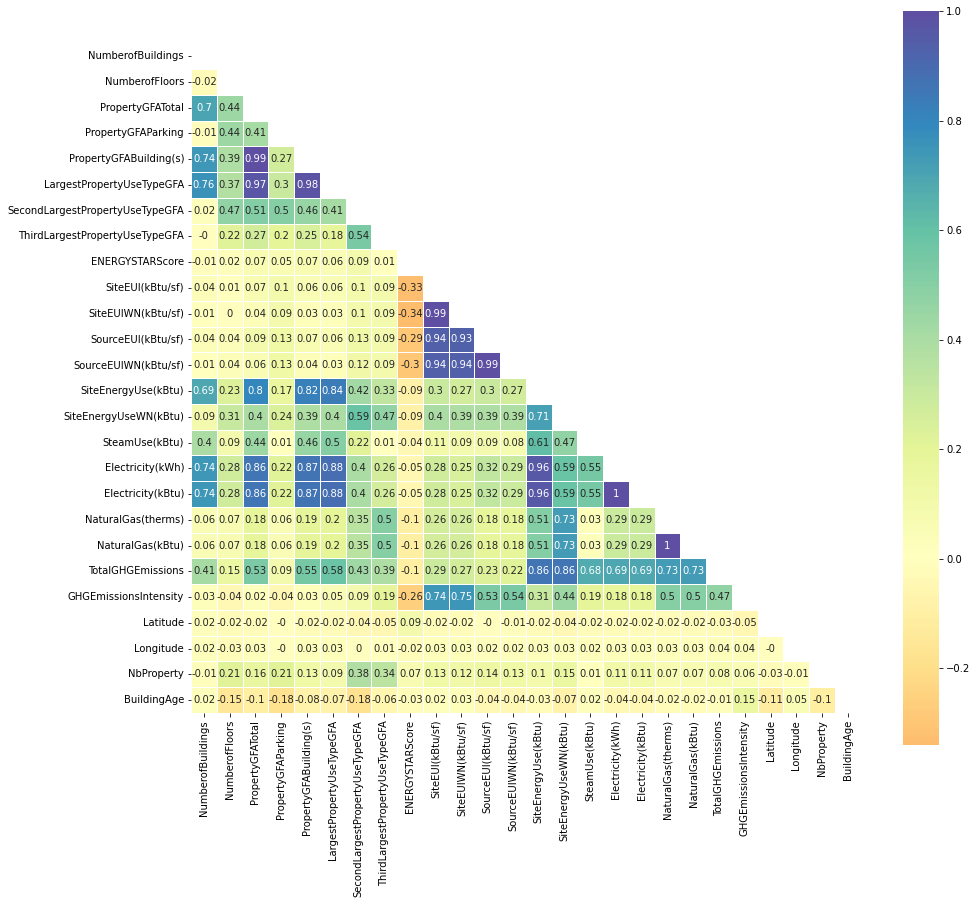

In [89]:
def plot_corr(df_):
    corr = df_.corr()
    #print(corr)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool_)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 27))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr.round(2), mask=mask, center=0, square=True, cmap='Spectral', linewidths=.5, cbar_kws={"shrink": .5}, annot=True);

plot_corr(df.select_dtypes("number"))

correlation including the categorical columns:

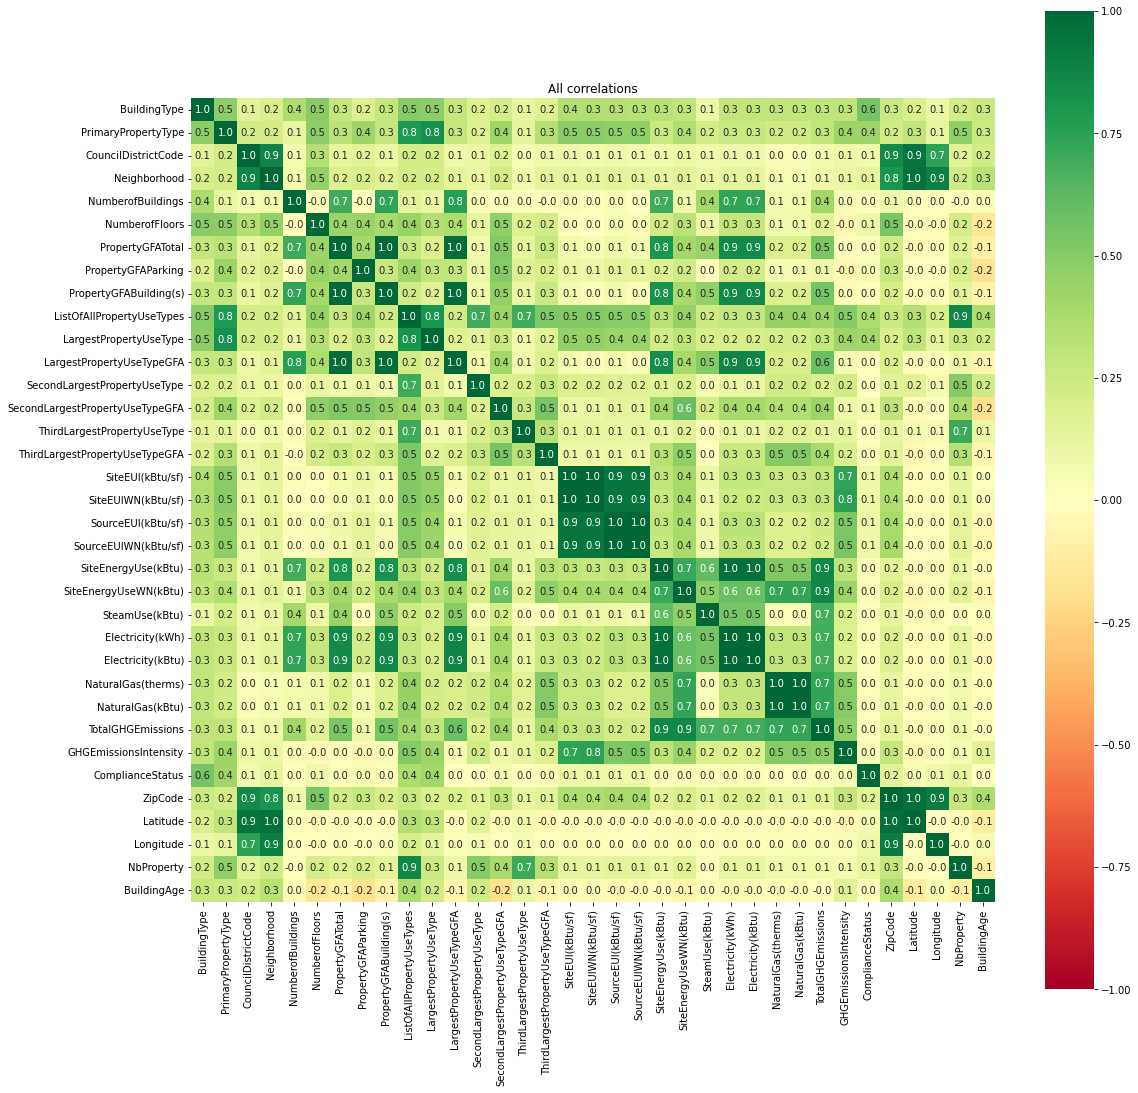

In [108]:
a = associations(df.drop(columns=["ENERGYSTARScore", "Outlier"]), figsize=(18, 18), fmt=".1f", cmap="RdYlGn", title="All correlations")

---
# Conclusions

That's the end of this first part. What have we seen so far?

Now we can save of dataset for the modelization in part 2 of this study.

In [ ]:
df.to_csv("./data/clean/2016_clean_dataset.csv", index=True, sep=";")